# Segmentasi Gambar dengan Clustering

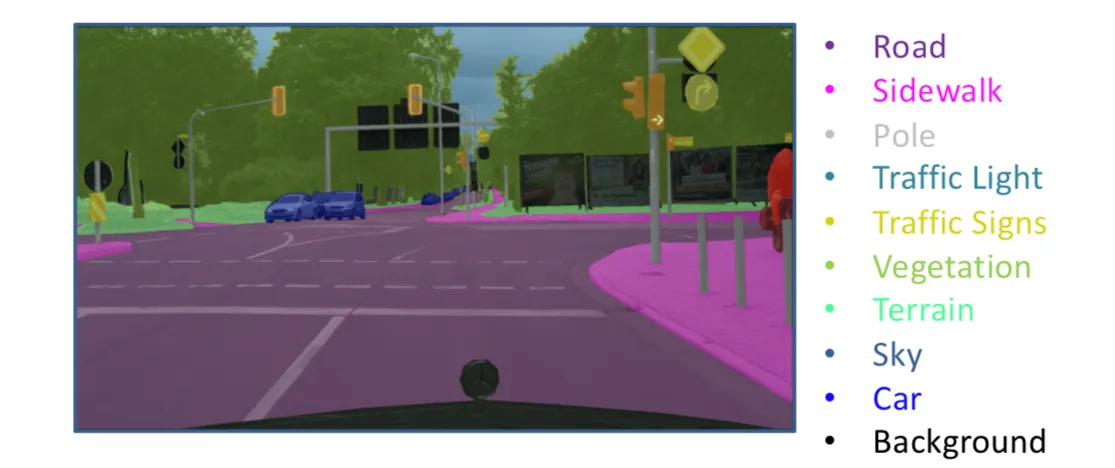

Segmentasi merupakan salah satu cara untuk membedakan antara objek satu dengan objek lainnya dalam suatu citra. Cara ini dapat dilakukan dengan mengelompokkan nilai pixel citra berdasarkan kedekatan warnanya.

Pada UTS kali ini, Anda diminta untuk melakukan segmentasi citra plat nomor kendaraan di Indonesia. Fungsi segmentasi dalam kasus ini adalah mempermudah pembacaan plat nomor kendaraan sebelum proses selanjutnya, seperti pembacaan karakter pada plat nomor.

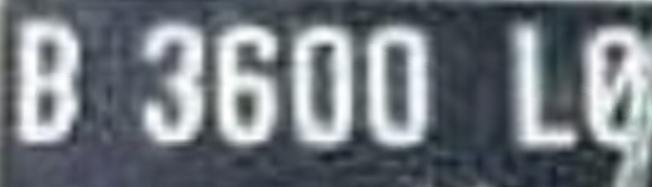

# Ketentuan UTS

Berdasarkan pemaparan kasus, Anda diminta untuk,

1. Pilih 5 citra plat nomor untuk setiap anggota kelompok dari dataset yang telah disediakan. [DOWNLOAD](https://storage.googleapis.com/kuliah_mah/dummy.zip)
2. Lakukan segmentasi pada citra plat nomor untuk memperjelas karakter pada plat nomor.
3. Anda dapat menggunakan algortima K-Means seperti yang telah dijelaskan pada praktikum sebelumnya atau menggunakan algoritma klasterisasi yang lain.
4. Anda diperkenankan untuk melakukan pra pengolahan data (preprocessing) pada citra seperti,
    - Merubah color space
    - Reduksi dimensi
    - dsb
5. Tampilkan perbandingan citra antara sebelum dan sesudah di segmentasi

**Open Challange** (Opsional)
 - Bagaimana cara melakukan evaluasi pada hasil segementasi?
 - Terapkan pada kasus ini!


**Catatan:**
1. Proses loading citra dicontohkan dengan menggunakan library openCV
2. Secara default, openCV akan memuat citra dalam format BGR

# Kode Bantuan

In [1]:
%pip install opencv-python imutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
# import imutils
# from google.colab.patches import cv2_imshow # path cv2.imshow di google colab

In [3]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
# Load Gambar
plates=[]
for img in glob.glob("data/*.jpg"):
    n = cv2.imread(img)
    plates.append(n)

## Membuat ground label dan images

In [5]:
# create black image with text like indonesian plate
def create_plate_image(shape=(200,700),text=''):
    img = np.zeros((shape), np.uint8)
    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale = 4
    font_thickness = 4
    text_color = (255, 255, 255)

    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_x = (shape[1] - text_size[0]) // 2
    text_y = (shape[0] + text_size[1]) // 2

    cv2.putText(img, text, (text_x, text_y), font, font_scale, text_color, font_thickness)
    return img

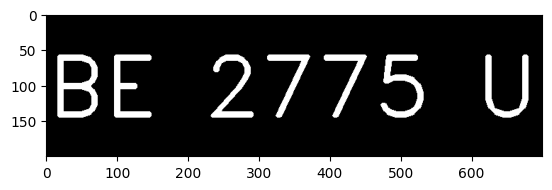

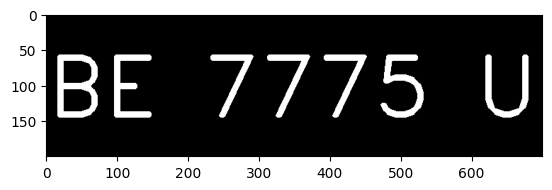

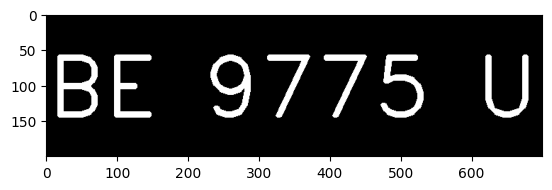

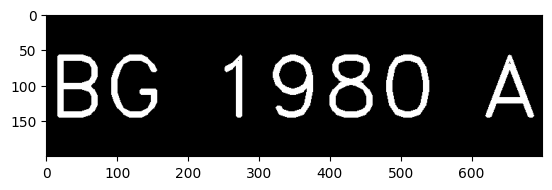

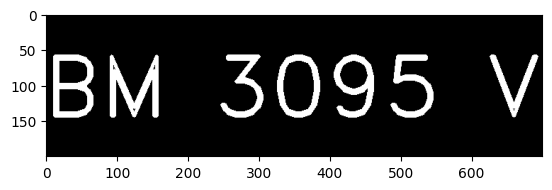

In [6]:
ground_labels = ["BE 2775 U","BE 7775 U","BE 9775 U","BG 1980 A","BM 3095 V"]
ground_images = []
for i,img in enumerate(ground_labels):
    ground = create_plate_image(text=ground_labels[i])
    ground_images.append(ground)
    showImage(ground)

## Preprocessing

In [7]:

from skimage import transform
#resize
def transforming(image,shape):
  result = transform.resize(image,shape)
  return (result*255).astype(np.uint8)
# grayscale
def grayscaling(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image,ksize=5):
    return cv2.medianBlur(image,ksize)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image,ksize=5,iterations=1):
    kernel = np.ones((ksize,ksize),np.uint8)
    return cv2.dilate(image, kernel, iterations = iterations)
    
#erosion
def erode(image,ksize=5,iterations=1):
    kernel = np.ones((ksize,ksize),np.uint8)
    return cv2.erode(image, kernel, iterations  = iterations)

#opening - erosion followed by dilation
def opening(image,ksize=5):
    kernel = np.ones((ksize,ksize),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def cannying(image):
    return cv2.Canny(img, 100, 200) 

#skew correction
def deskew(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0) 
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated



In [8]:
# plot pixels in 3d with scatter plot

from sklearn.cluster import MiniBatchKMeans
def segment_image(image):
    # to 2 color
    kmeans = MiniBatchKMeans(2,n_init=10)
    kmeans.fit(image)
    segmented = kmeans.cluster_centers_[kmeans.predict(image)]
    return segmented


Plate 1


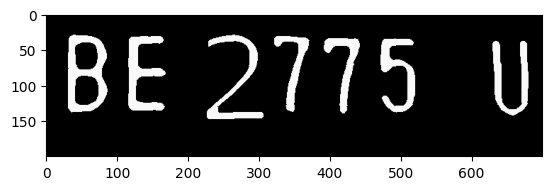

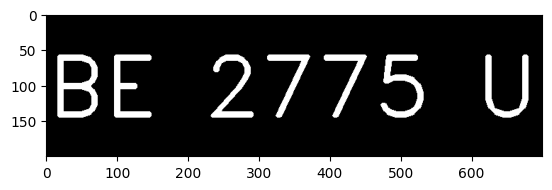

Plate 2


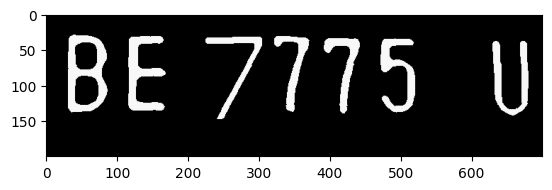

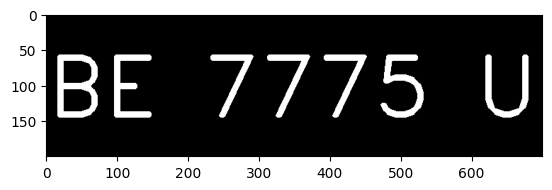

Plate 3


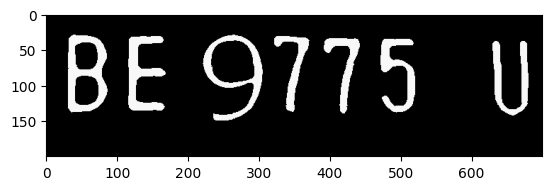

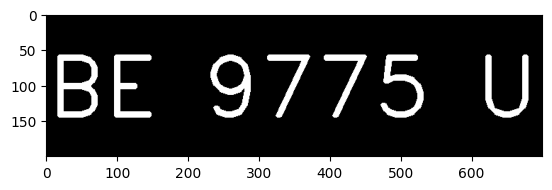

Plate 4


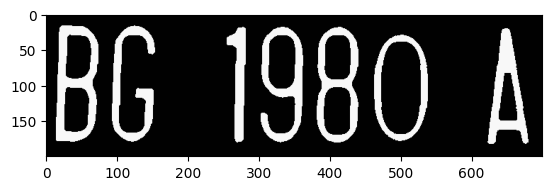

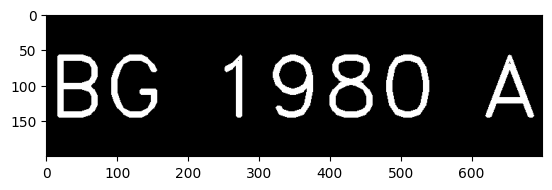

Plate 5


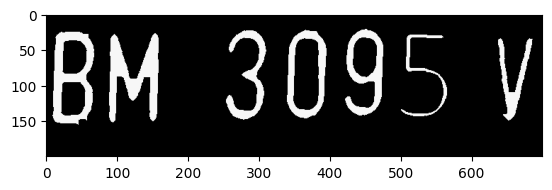

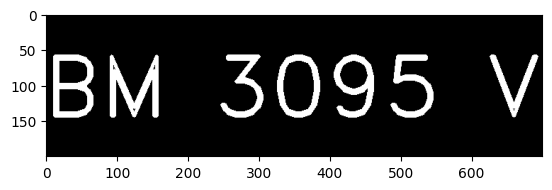

In [25]:
results = []

skew_angles = [1,1,1,-1,-2]
for i,img in enumerate(plates):
  #preprocessing
  resized = transforming(img,ground_images[i].shape)
  gray = grayscaling(resized)
  blur = remove_noise(gray)
  opened = opening(blur)
  eroded = erode(opened,4,2)
  # dilated= dilate(opened,4,3)
  thresh = thresholding(eroded)
  # cannyed = canny(eroded)
  deskewed = deskew(thresh,skew_angles[i])

  #segmentation
  pixels =  deskewed/255
  segmented = segment_image(pixels.reshape((-1,1)))
  segmented = (segmented.reshape(deskewed.shape)*255).astype(np.uint8)
  results.append(segmented)
  print(f"Plate {i+1}")
  showImage(segmented)
  showImage(ground_images[i])



## Evaluasi segmentasi gambar dengan gambar ground

In [26]:
#find contours
def find_contours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    # cnt = contours[0]
    # x,y,w,h = cv2.boundingRect(cnt)
    return contours

def crop_words(image, contours):
        counter = 0
        words = []
        for i in contours:
            x, y, w, h = cv2.boundingRect(i)
            cropped = img[y:y + h, x:x + w]
            width, height = cropped.shape[:2]

            if width * height > 200:
                words.append(cropped)
            counter = counter + 1

        return reversed(words)

def draw_rect(image,contours):
    for i in contours:
        x, y, w, h = cv2.boundingRect(i)
        if (h*w) < 25:
            return
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), 1)
    # showImage(image)
    return image

Plate 1 : 7


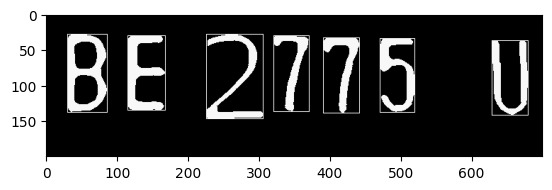

Plate 2 : 7


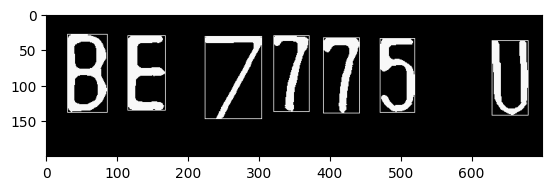

Plate 3 : 7


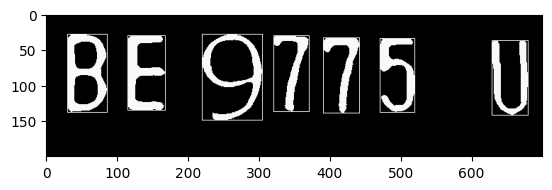

Plate 4 : 1


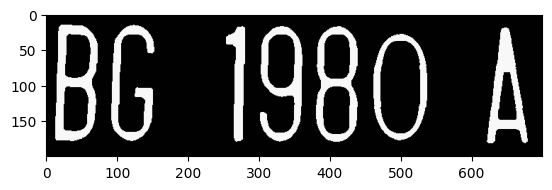

Plate 5 : 7


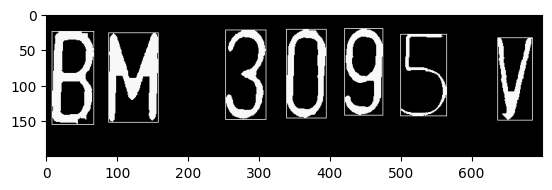

In [20]:
for i,result in enumerate(results):
  contours = find_contours(result)
  cropped_words = crop_words(result,contours)
  # for word in cropped_words: 
  #   showImage(word)
  draw_rect(result,contours)
  # draw_rect(plates[i],contours)
  print(f"Plate {i+1} : {len(list(cropped_words))}")
  showImage(results[i])

In [27]:
# pixel accuracy
def pixel_accuracy(pred,ground):
  correct_pixels = (pred == ground).sum()
  total_pixels = pred.size
  pixel_acc = correct_pixels / total_pixels
  return pixel_acc

# dice coefficient
def dice_coefficient(pred,ground):
  intersection = np.sum(pred & ground)
  total_pixels = np.sum(pred) + np.sum(ground)
  dice = 2 * intersection / total_pixels
  return dice

#jaccard index
def jaccard_index(pred,ground):
  intersection = np.sum(pred & ground)
  union = np.sum(pred | ground)
  jaccard = intersection / union
  return jaccard



In [28]:
from sklearn.metrics import classification_report

for i,result in enumerate(results):
  print("\nPlate",i+1)
  print("Pixel Accuracy:",pixel_accuracy(result,ground_images[i]))
  print("Jaccard Index:",jaccard_index(result,ground_images[i]))
  print("Dice Coefficient:",dice_coefficient(result,ground_images[i]))


Plate 1
Pixel Accuracy: 0.8301928571428572
Jaccard Index: 0.14078509101085962
Dice Coefficient: 0.24682140767830113

Plate 2
Pixel Accuracy: 0.8357357142857142
Jaccard Index: 0.14072635376590398
Dice Coefficient: 0.2467311345991457

Plate 3
Pixel Accuracy: 0.8225857142857143
Jaccard Index: 0.12067805856099995
Dice Coefficient: 0.2153661484475852

Plate 4
Pixel Accuracy: 0.0
Jaccard Index: 0.17551861504949168
Dice Coefficient: 0.29862328473990524

Plate 5
Pixel Accuracy: 0.8087
Jaccard Index: 0.19343484493143911
Dice Coefficient: 0.3241649022616758


## Evaluasi segmentasi gambar dengan label ground

In [29]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\USER\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
pytesseract.get_tesseract_version()

<Version('5.3.3.20231005')>

In [30]:

import difflib
for i,img in enumerate(results):
  text = pytesseract.image_to_string(img, lang='eng')
  print(f'Plate {i+1} : {text}')
  print(f'Ground {i+1} : {ground_labels[i]}')
  print(f'Seberapa mirip: {difflib.SequenceMatcher(None, text.strip(), ground_labels[i]).ratio()}')

Plate 1 : BE 2775 U

Ground 1 : BE 2775 U
Seberapa mirip: 1.0
Plate 2 : BE 7775 U

Ground 2 : BE 7775 U
Seberapa mirip: 1.0
Plate 3 : BE 9775 U

Ground 3 : BE 9775 U
Seberapa mirip: 1.0
Plate 4 : 
Ground 4 : BG 1980 A
Seberapa mirip: 0.0
Plate 5 : BM 3095 V

Ground 5 : BM 3095 V
Seberapa mirip: 1.0


In [31]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=14)